# Learning factors for stock market returns prediction

This notebook presents various approaches to solve QRT data challenge published in 2022. A detailed description is available [here](https://challengedata.ens.fr/participants/challenges/72/).


Contents
--------
1. [Problem overview](#intro)
2. [Exploratory data analysis](#eda)
3. [Utilities](#utils)
4. [Problem reduction](#reduction)
4. [Regularized linear model](#linreg)
5. [Bruteforce v2](#bruteforce)
5. [Random projection](#random_proj)
5. [Gradient descent](#sgd)
5. [Regularized gradient descent](#reg_sgd)
6. [Conclusion and perspectives](#conclusion)

## <a id="intro"></a> Problem overview

We are given a dataset consisting of daily price returns over three years for a selection of $N=50$ market stocks. The goal is to predict the next-day returns given the past values. Mathematically, denoting $R_{t}$ the vector of returns at time $t$ for the $N$ stocks, we assume a relation 
$$
  R_{t+1} = f\left( \{ R_k \}_{k\leq t}  \right) + \epsilon_{t+1},
$$
where $\epsilon$ is a noise contribution.

In the context of this project, we look for a predictor $f$ that is a linear combination of the past returns. We thus look for explicative factors $F_{i, t}$ such that the predicted returns $\hat{R}_{t+1}$ take the form:
$$
  \hat{R}_{t+1} = \sum_{i=1}^{F} \beta_i \, F_{i, t},
$$
$$
  F_{i, t} = \sum_{j=1}^{D} A_{i, j} \, R_{t+1-j},
$$
with
- $F = 10$, the maximal number of factors;
- $D = 250$, the time depth limit (about 1 year);
- vectors $\{A_i\}_{1\leq i \leq F}$ are orthonormal, ie $\langle A_i,A_j \rangle = \delta_{ij}$.

The metric associated to this problem is the mean cosine similarity between the prediction and the actual value:
$$
  \mathcal{M}(A, \beta) = \frac{1}{T} \sum_{t > D} \frac{\langle \hat{R}_t,R_t \rangle}{\| \hat{R}_t \| \| R_t \|},
$$
where $T$ is the number of predicted returns (here $T = 504$ given that we have the returns for $754$ days).

The vectors $A_i$ can be determined empirically from financial expertise. Such empirical quantities include the 5-day normalized mean returns $R_t^{(5)}$ and the momentum $R_{t-20}^{(230)}$, where
$$
  R_{t}^{(m)} = \frac{1}{\sqrt{m}} \sum_{k=1}^{m} R_{t+1-k}.
$$
The parameters $\beta$ are then fit to market data. These factors have the advantage of being easily interpretable, but are fairly constrained and do not perform very well. The goal of this project is to find explicative factors directly from the data.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (mean_squared_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error)
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler,
                                   FunctionTransformer)
from sklearn.linear_model import LinearRegression, Lasso

## <a id="eda"></a> Exploratory data analysis

We begin the study with a preliminary data analysis in order to get insights about the content of the dataset, and the structure and distribution of price returns.

In [15]:
stock_returns = np.loadtxt('./X_train.csv', delimiter=',', skiprows=1)[:, 1:]

### Stock returns overview

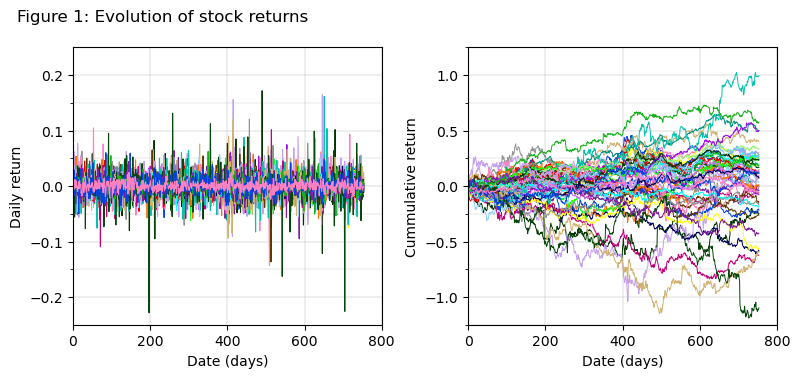

In [16]:
COLORS = [
    '#7e1e9c', '#15b01a', '#0343df', '#ff81c0', '#653700', '#e50000',
    '#95d0fc', '#029386', '#f97306', '#96f97b', '#c20078', '#ffff14',
    '#75bbfd', '#929591', '#0cff0c', '#bf77f6', '#9a0eea', '#033500',
    '#06c2ac', '#c79fef', '#00035b', '#d1b26f', '#00ffff', '#06470c',
    ]


fig1, axs1 = plt.subplots(
    nrows=1, ncols=2, sharey=False, figsize=(8, 3.8), dpi=100,
    gridspec_kw={'left': 0.09, 'right': 0.97, 'top': 0.88, 'bottom': 0.15, 'wspace': 0.28})
fig1.suptitle("Figure 1: Evolution of stock returns",
              x=0.02, ha='left')

# Returns
for i, sr in enumerate(stock_returns):
    axs1[0].plot(sr, linewidth=0.8, color=COLORS[(i+2)%24])

axs1[0].set_xlim(0, 800)
axs1[0].set_xlabel('Date (days)')
axs1[0].set_ylim(-0.25, 0.25)
axs1[0].set_yticks([-0.15, -0.05, 0.05, 0.15], minor=True)
axs1[0].set_ylabel('Daily return')
axs1[0].grid(visible=True, linewidth=0.3)
axs1[0].grid(visible=True, which='minor', linewidth=0.2)

# Cummulative returns
for i, sr in enumerate(np.cumsum(stock_returns, axis=1)):
    axs1[1].plot(sr, linewidth=0.7, color=COLORS[(i+2)%24])

axs1[1].set_xlim(0, 800)
axs1[1].set_xlabel('Date (days)')
axs1[1].set_ylim(-1.25, 1.25)
axs1[1].set_yticks([-1.25, -0.75, -0.25, 0.25, 0.75, 1.25], minor=True)
axs1[1].set_ylabel('Cummulative return')
axs1[1].grid(visible=True, linewidth=0.3)
axs1[1].grid(visible=True, which='minor', linewidth=0.2)


plt.show()

We plot in figure 1, for each stock, the returns variation over time (left panel) and the accumulated values (right panel). Most values are between -0.05 and 0.05, yet we also note the presence of extreme events with very large returns (both positive and negative). We can see the price kick caused by some of these events on the right panel (see for instance the green curve in the bottom right).

### Price returns distribution

In [17]:
vals = np.logspace([-4], [0], 81)
pos_returns_cdf = np.mean(stock_returns.ravel() >= vals, axis=1)
neg_returns_cdf = np.mean(stock_returns.ravel() <= -vals, axis=1)

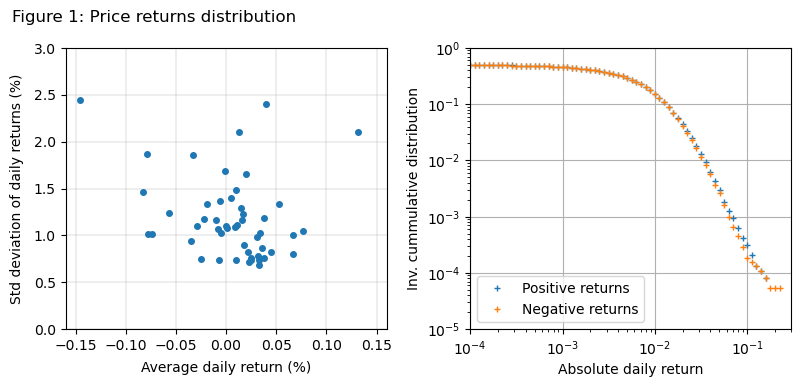

In [18]:
fig2, axs2 = plt.subplots(
    nrows=1, ncols=2, sharey=False, figsize=(8.2, 3.8), dpi=100,
    gridspec_kw={'left': 0.085, 'right': 0.97, 'top': 0.88, 'bottom': 0.14, 'wspace': 0.26})
fig2.suptitle("Figure 1: Price returns distribution",
              x=0.02, ha='left')

axs2[0].plot(100*np.mean(stock_returns, axis=1),
             100*np.std(stock_returns, axis=1),
         linestyle='', marker='o', markersize=4)

axs2[0].set_xlim(-0.16, 0.16)
axs2[0].set_xlabel('Average daily return (%)', labelpad=6)
axs2[0].set_ylim(0, 3)
axs2[0].set_ylabel('Std deviation of daily returns (%)', labelpad=7)
axs2[0].grid(visible=True, linewidth=0.3)

axs2[1].plot(vals, pos_returns_cdf, marker='+', linestyle='', markersize=4,
             label='Positive returns')
axs2[1].plot(vals, neg_returns_cdf, marker='+', linestyle='', markersize=4,
             label='Negative returns')
axs2[1].set_xscale('log')
axs2[1].set_xlim(1e-4, 3e-1)
axs2[1].set_yscale('log')
axs2[1].set_ylim(1e-5, 1)
axs2[1].grid(visible=True)
axs2[1].set_xlabel('Absolute daily return')
axs2[1].set_ylabel('Inv. cummulative distribution')
axs2[1].legend()


plt.show()

We present in figure 2 a scatter plot of the mean and standard deviation of returns for each stock (left panel), and the inverse cummulative distribution of the returns (right panel).

The daily returns of each stock have zero mean, this indicates a preprocessing of the original values. The standard deviations for the various stocks are in the range 0.5 - 2.5%, with most values between 0.5 and 1.5%.

The inverse cummulative distribution corresponds to $P(R \geq x)$ (positive returns) and $P(R \leq -x)$ (negative returns). We plot the values from the merged stocks. The global returns distribution is almost perfectly symmetric. Most of the returns fall in the range 0.001-0.01. Extreme returns, larger than 0.1, are not uncommon, and occur with a probability of about 1/2500. These extreme events can reach an amplitude of $10\sigma$, which is virtually impossible for gaussian processes.

### Dependence of the returns on the week day

The daily stock returns correspond to working days. However, we could expect monday stock returns to have larger variations than the other days. This would be due to the fact that monday follows the week end, which provides a longer time for market-affecting events to occur (therefore a higher probability of such events).

In the context of this project, the required convolutional model would be unable to capture such periodicity in returns.

In [19]:
k = 5
returns_std = np.std(stock_returns, axis=1)
returns_mod = [stock_returns[:, i::k] for i in range(k)]

day_means = [np.mean(np.mean(x, axis=1) / returns_std) for x in returns_mod]
day_stds = [np.mean(np.std(x, axis=1) / returns_std) for x in returns_mod]

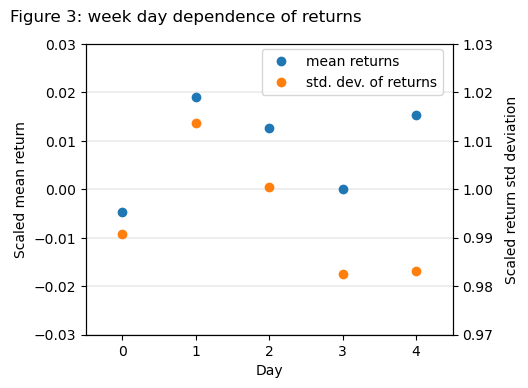

In [20]:
fig3, ax3 = plt.subplots(
    nrows=1, ncols=1, sharey=True, figsize=(5.4, 3.8), dpi=100,
    gridspec_kw={'left': 0.16, 'right': 0.84, 'top': 0.89, 'bottom': 0.125})
fig3.suptitle("Figure 3: week day dependence of returns",
              x=0.02, ha='left')

# day means
l_mean, = ax3.plot(day_means, linestyle='', marker='o')
ax3.set_xlim(-0.5, 4.5)
ax3.set_xlabel('Day')
ax3.set_ylim(-0.03, 0.03)
# ax3.set_yticks([-0.15, -0.05, 0.05, 0.15], minor=True)
ax3.set_ylabel('Scaled mean return')
ax3.grid(visible=True, axis='y', linewidth=0.3)

# day std deviations
ax3_twin = ax3.twinx()
l_std, = ax3_twin.plot(day_stds, linestyle='', marker='o', color='tab:orange')
ax3_twin.set_xlim(-0.5, 4.5)
ax3_twin.set_xlabel('Day')
ax3_twin.set_ylim(0.97, 1.03)
ax3_twin.set_ylabel('Scaled return std deviation', labelpad=8)


fig3.legend(handles=[l_mean, l_std],
            labels=['mean returns', 'std. dev. of returns'],
            ncols=1, loc=(0.495, 0.755), alignment='center')

plt.show()

Figure 3 presents the mean and standard deviations for each week day of the merged returns. The data is scaled by the standard deviation across the whole dataset. There seems to be no incidence of the week day on the returns. The given values certainly correspond to intra-day returns, which by construction must be insensitive to inter-day variations.

### Correlations between stock prices

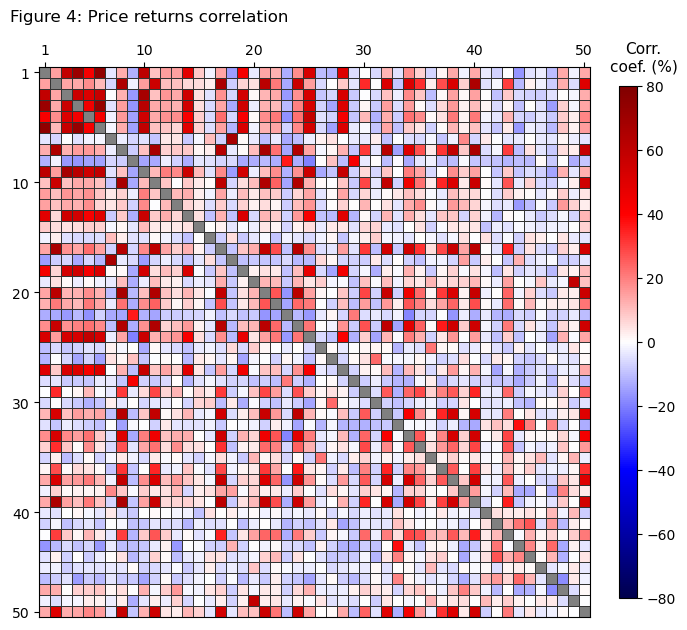

In [21]:
fig4, ax4 = plt.subplots(
    nrows=1, ncols=1, figsize=(7, 6.4), dpi=100,
    gridspec_kw={'left': 0.03, 'right': 0.88, 'top': 0.89, 'bottom': 0.03, 'wspace': 0.24})
cax4 = fig4.add_axes((0.89, 0.06, 0.025, 0.8))
fig4.suptitle("Figure 4: Price returns correlation", x=0.02, ha='left')


ax4.set_aspect('equal')
cmap4 = plt.get_cmap('seismic').copy()
cmap4.set_extremes(under='0.9', over='0.5')
heatmap = ax4.pcolormesh(100*np.corrcoef(stock_returns)[::-1],
                         cmap=cmap4, vmin=-80, vmax=80,
                         edgecolors='0.2', linewidth=0.5)

ax4.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax4.set_xticks([0.5, 9.5, 19.5, 29.5, 39.5, 49.5], [1, 10, 20, 30, 40, 50])
ax4.set_yticks([49.5, 39.5, 29.5, 19.5, 9.5, 0.5], [1, 10, 20, 30, 40, 50])


pos = ax4.get_position().bounds
x, y = pos[0], pos[1] + pos[3]

fig4.colorbar(heatmap, cax=cax4, orientation="vertical", ticklocation="right")
cax4.text(1.4, 1.03, 'Corr.\ncoef. (%)', fontsize=11, ha='center', transform=cax4.transAxes)


plt.show()

We present in figure 4 the correlation matrix of the prices returns for the 50 stocks of the dataset. The stocks are rather positively correlated, with correlation coefficients as large as 75% for some pairs. The negative correlations are less pronounced, extending to as low as -20%.

## <a id="utils"></a> Utilities

Before proceeding, we need to setup some utility functions. To avoid clogging the notebook, they are defined in the separate file `utils.py`.

In [22]:
## import utils
from utils import (to_csv, vector_to_vectors,
                   metric, SGDOptimizer, 
                   grad_metric, grad_l1_diff, grad_l1_absdiff)

In [23]:
## setup parameters and variables
n_stocks = 50
n_factors = 10
depth = 250
n_steps = stock_returns.shape[1] - depth
X = np.stack([stock_returns[:, i:i+depth] for i in range(n_steps)])
Y = np.stack([stock_returns[:, i+depth] for i in range(n_steps)])

## <a id="reduction"></a> Problem reduction

It turns out that the problem formulation brings unnecessary complexity. We can simplify the predicted returns equation to get
$$
  \hat{R}_{t+1} = \sum_{j=1}^{D} w_j \, R_{t+1-j},
$$
where
$$
  w_j = \sum_{i=1}^{F} \beta_i \, A_{i, j}.
$$
This formulation is mathematically equivalent to the original yet has several advantages:
- A reduction by a factor about $D=10$ of the number of parameters for the model, reducing both the risk of overfitting and the speed of calculations.
- We get rid of the requirement to enforce the orthonormality of the explanatory factors.
These benefits come at the cost of the interpretabiliy of the model. We could indeed expect a collection of factors to reflect a different aspect of the market dynamics (as the 5-day mean and momentum does). However, merging them as one mixes the contributions.

It is also worth noting that the targets $R_t$ appear only in normalized form in the metric of eq.~\ref{eq:Metric}. We therefore can replace them with $\tilde{R}_t = R_t / \| R_t \|$ without any change but a simplification of the computations.

To submit a solution, we are required to provide a list of orthonormal vectors, along with their norm. We produce them from the single vector $\mathbf{w}$:
- $A_{ij} = \delta_{i,j},\ 0 \leq i \leq 8$; $A_9 = a_{9:D} / ||a_{9:D}||$
- $\beta_i = w_i,\ 0 \leq i \leq 8$; $\beta_9 = ||a_{9:D}||$
The code below illustrates this vector transformation with the two factors $R^{(5)}_t$ and $R^{(250)}_{t-20}$. The fitted values $\beta = (-0.00694934, 0.01560642)$ are obtained from the explanatory notebook.

In [24]:
a = np.zeros(250, dtype=float)
a[0:5] = -0.00694934/np.sqrt(5)
a[20:250] = 0.01560642/np.sqrt(230)

Y_pred = np.sum(X*a[::-1], axis=-1)
print(metric(Y_pred, Y)) # same as the value from the notebook

0.019538512753470835


## <a id="linreg"></a> Regularized linear regression

The simplest approach to find a predictor as a linear combination of past returns is to make a linear regression to find the corresponding weights. However, the model must be strongly regularized in order to avoid overfitting. Furthermore, the metric being invariant by a rescaling of the weights vectors (which is what ridge penalizes), we retain the lasso regularization for the regression.

The targets only appear in the metric in normalized form, it is therefore natural to normalize the vector prior to training. In theory, the features should not be normalized (only the predicted vectors are normalized), however, it turns out that doing so improves the results.

In [25]:
## normalize features and targets
YY = Y / np.sqrt(np.sum(Y**2, axis=1, keepdims=True))
XX = X / np.sqrt(np.sum(X**2, axis=1, keepdims=True))

In [26]:
## training metric
model = Lasso(alpha=1, fit_intercept=False)
alphas = np.concatenate([np.logspace(-6, -4, 11), np.logspace(-4, -3, 11)])
tr_metric = np.full_like(alphas, -1, dtype=float)
for i, alpha in enumerate(alphas):
    model.alpha = alpha
    model.fit(XX.reshape(-1, depth), YY.ravel())
    weights = model.coef_
    
    Y_pred = np.sum(X*weights, axis=-1)
    tr_metric[i] = metric(Y_pred, Y)

d:\dev\stock-market-returns-prediction\utils.py:23: RuntimeWarning: invalid value encountered in divide
  return np.mean(scalar_product/(norm_true*norm_pred), axis=-1)
d:\dev\stock-market-returns-prediction\utils.py:23: RuntimeWarning: invalid value encountered in divide
  return np.mean(scalar_product/(norm_true*norm_pred), axis=-1)
d:\dev\stock-market-returns-prediction\utils.py:23: RuntimeWarning: invalid value encountered in divide
  return np.mean(scalar_product/(norm_true*norm_pred), axis=-1)


In [27]:
## validation metric
cv = KFold(n_splits=10, shuffle=True, random_state=1234)
val_metric = np.full_like(alphas, -1, dtype=float)
for i, alpha in enumerate(alphas):
    model.alpha = alpha
    Y_pred = np.zeros_like(Y, dtype=float)
    for itr, ival in cv.split(XX, YY):
        X_tr = XX[itr].reshape(-1, depth)
        Y_tr = YY[itr].ravel()
        model.fit(X_tr, Y_tr)
        X_v = XX[ival].reshape(-1, depth)
        Y_pred[ival] = model.predict(X_v).reshape(-1, n_stocks)
    val_metric[i] = metric(Y_pred, Y)

d:\dev\stock-market-returns-prediction\utils.py:23: RuntimeWarning: invalid value encountered in divide
  return np.mean(scalar_product/(norm_true*norm_pred), axis=-1)
d:\dev\stock-market-returns-prediction\utils.py:23: RuntimeWarning: invalid value encountered in divide
  return np.mean(scalar_product/(norm_true*norm_pred), axis=-1)
d:\dev\stock-market-returns-prediction\utils.py:23: RuntimeWarning: invalid value encountered in divide
  return np.mean(scalar_product/(norm_true*norm_pred), axis=-1)


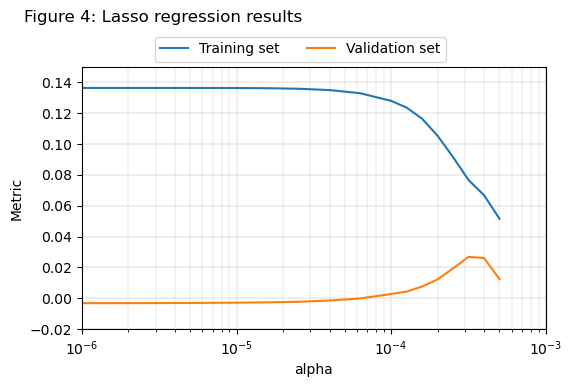

In [28]:
fig5, ax5 = plt.subplots(
    nrows=1, ncols=1, sharey=True, figsize=(5.8, 3.8), dpi=100,
    gridspec_kw={'left': 0.12, 'right': 0.92, 'top': 0.83, 'bottom': 0.14})
fig5.suptitle("Figure 4: Lasso regression results", x=0.02, ha='left')


l_tr, = ax5.plot(alphas, tr_metric, linestyle='-', marker='')
l_val, = ax5.plot(alphas, val_metric, linestyle='-', marker='')
ax5.set_xscale('log')
ax5.set_xlim(1e-6, 1e-3)
ax5.set_xlabel('alpha')
ax5.set_ylim(-0.02, 0.15)
ax5.set_ylabel('Metric')
ax5.grid(visible=True, linewidth=0.3)
ax5.grid(visible=True, which='minor', linewidth=0.2)

fig5.legend(handles=[l_tr, l_val],
            labels=['Training set', 'Validation set'],
            ncols=2, loc=(0.27, 0.84), alignment='center')

plt.show()

The model performs poorly on the validation set for $\alpha < 10^{-4}$. However, the validation score increases past this threshold to reach about 0.025 at $\alpha = 3 \cdot 10^{-4}$, which is similar to the benchmark score. Further increasing alpha yields a model with vanishing coefficients (hence a division by zero in the metric computation). However, the validation score actually depends strongly on the cross-validation splits.

### Model interpretation

Let us study the weight vector found in the optimal case $\alpha = 3 \cdot 10^{-4}$.

In [29]:
model = Lasso(alpha=3e-4, fit_intercept=False)
model.fit(XX.reshape(-1, depth), YY.ravel())
model.coef_

array([-0.        ,  0.        ,  0.00042962,  0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.00072039,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00044746,  0.        ,  0.01245957,  0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.  

The optimal weight vector found is very sparse! Only 19/250 coefficients are non-zero, and the actual values and positions appear random. We obtained a random sparse vector, which is quite unsatisfactory.

## <a id="bruteforce"></a> Bruteforce v2

Having reduced the problem, we can now apply the bruteforce approach more efficiently.

In [30]:
rng = default_rng(1234)

niter = 20
best_metric = -1
for i in range(niter):
    vectors = rng.normal(size=(10000, depth))
    Y_pred = np.tensordot(vectors, X, [[1], [2]])
    res = metric(Y_pred, Y)
    
    best_idx = np.argmax(res)
    if res[best_idx] > best_metric:
        best_metric = res[best_idx]
        best_vector = vectors[best_idx]
        print(f'iteration {i}, best metric :', best_metric)

print(best_metric)

iteration 0, best metric : 0.033752583437037235
iteration 2, best metric : 0.039858559530289245
iteration 12, best metric : 0.053863770323352246
0.053863770323352246


Not bad! We get results similar to the benchmark. Two differences though:
- We tried 200k solutions instead of 1000*10 vectors;
- Having the solution in 'merged' form, we could not fit individual contributions.

All in all, this approach seems to have roughly the same efficiency as that of the notebook. What we gain in sampling speed we lose in optimization freedom.

## <a id="random_proj"></a> Random projection

## <a id="sgd"></a> Gradient descent

The metric used for assessment of the model performance is unusual for such regression problem. To our knowledge, there is no optimization algorithm available in a Python package that is suitable to maximize the metric. However, the problem is simple enough to implement gradient descent from scratch. With the problem framed as a search for a single vector, the metric can be written 
$$
  \mathcal{M}(\mathbf{w}) = \frac{1}{T} \sum_{t>D} \frac{\mathbf{w}^{\top} \mathbf{R}^{\top}_{t-D:t} R_t}{\| \mathbf{R}_{t-D:t} \mathbf{w} \| \| R_t \|},
$$
where $\mathbf{R}_{t-D:t}$ is the $250\times 50$ matrix of returns between times $t-D$ and $t$ (excluded).

The gradient has the form
$$
\nabla_{\mathbf{w}} \mathcal{M}(\mathbf{w}) = \frac{1}{T} \sum_{t} \frac{\mathbf{R}^{\top}_{t-D:t} R_t}{\| \mathbf{R}_{t-D:t} \mathbf{w} \| \| R_t \|} - \frac{1}{T} \sum_{t} \frac{\mathbf{R}^{\top}_{t-D:t}\mathbf{R}_{t-D:t} \mathbf{w} \, \mathbf{w}^{\top} \mathbf{R}^{\top}_{t-D:t} R_t}{\| \mathbf{R}_{t-D:t} \mathbf{w} \|^2 \| R_t \|}.
$$
This expression can be written in simpler terms as
$$
\nabla_{\mathbf{w}} \mathcal{M}(\mathbf{w}) = \frac{1}{T} \sum_{t} \mathbf{R}^{\top}_{t-D:t} \left[ \frac{\tilde{R}_t}{\| \hat{R}_{t} \|} - \frac{\langle \hat{R}_t, \tilde{R}_t \rangle \hat{R}_t}{\| \hat{R}_{t} \|^2}  \right],
$$
where we used the normalized target returns $\tilde{R}_t = R_t / \| R_t \|$, and the predicted returns $\hat{R}_t = \mathbf{R}_{t-D:t} \mathbf{w}$. The second term in this expression is basically the projection of the target returns along the direction of the predicted returns. This term compensates the radial component of the first, ensuring that the gradient has no radial component.

With these results, we implemented a Nesterov stochastic gradient descent algorithm (`SGDOptimizer` in `utils.py`) to find the optimal weights.

In [31]:
## Initial weight vector
w0 = rng.normal(size=depth) # best_vector
w0 = w0 / np.sqrt(np.sum(w0**2)) 

## Set training parameters
n_epochs = 60
batch_size = 16
optimizer = SGDOptimizer(w0, learning_rate=0.05, momentum=0.0, nesterov=False)

In [32]:
## Compute training metric
rng = default_rng(1234)
idx = np.arange(len(X))
tr_metric = np.zeros(n_epochs+1, dtype=float)

Y_pred = np.sum(X * w0, axis=-1)
tr_metric[0] = metric(Y_pred, Y)
print(f'epoch 0/{n_epochs} : train metric {tr_metric[0]:.4f}')

for i in range(n_epochs):
    rng.shuffle(idx)
    for j in range((len(idx)+batch_size-1) // batch_size):
        X_ = X[idx[j*batch_size:(j+1)*batch_size]]
        Y_ = YY[idx[j*batch_size:(j+1)*batch_size]]
        w = optimizer.eval_point()
        grad = -grad_metric(X_, Y_, w)
        optimizer.apply_gradients(grad)
    
    Y_pred = np.sum(X * optimizer.weights, axis=-1)
    tr_metric[i+1] = metric(Y_pred, Y)
    if i % 10 == 9:
        print(f'epoch {i+1}/{n_epochs} : train metric {tr_metric[i]:.4f}')

epoch 0/60 : train metric -0.0090
epoch 10/60 : train metric 0.1402
epoch 20/60 : train metric 0.1436
epoch 30/60 : train metric 0.1439
epoch 40/60 : train metric 0.1437
epoch 50/60 : train metric 0.1444
epoch 60/60 : train metric 0.1438


In [33]:
## Compute validation metric
rng = default_rng(1234)
cv = KFold(n_splits=4, shuffle=True, random_state=1234)

val_metric = np.zeros(n_epochs+1, dtype=float)
val_metric[0] = tr_metric[0]
Y_pred = np.zeros((n_epochs,) + Y.shape, dtype=float)

for itr, ival in cv.split(X, YY):
    optimizer.reset(w0)
    X_v = X[ival]
    for i in range(n_epochs):
        rng.shuffle(itr)
        for j in range((len(itr)+batch_size-1) // batch_size):
            X_ = X[itr[j*batch_size:(j+1)*batch_size]]
            Y_ = YY[itr[j*batch_size:(j+1)*batch_size]]
            w = optimizer.eval_point()
            grad = -grad_metric(X_, Y_, w)
            optimizer.apply_gradients(grad)
        Y_pred[i, ival] = np.sum(X_v * optimizer.weights, axis=-1)
val_metric[1:] = metric(Y_pred, Y)

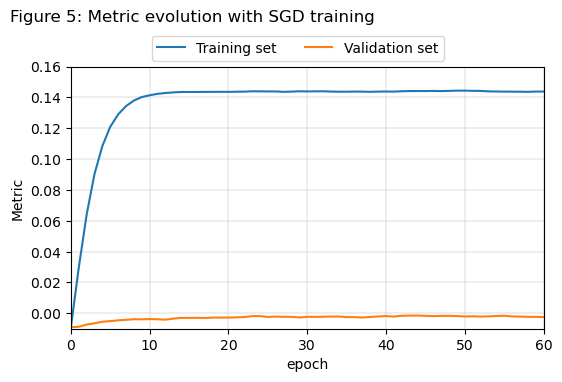

In [34]:
fig5, ax5 = plt.subplots(
    nrows=1, ncols=1, sharey=True, figsize=(5.8, 3.8), dpi=100,
    gridspec_kw={'left': 0.125, 'right': 0.94, 'top': 0.83, 'bottom': 0.14})
fig5.suptitle("Figure 5: Metric evolution with SGD training",
              x=0.02, ha='left')


l_tr, = ax5.plot(np.arange(n_epochs+1), tr_metric, linestyle='-', marker='')
l_val, = ax5.plot(np.arange(n_epochs+1), val_metric, linestyle='-', marker='')

ax5.set_xlim(0, n_epochs)
ax5.set_xlabel('epoch')
ax5.set_ylim(-0.01, 0.16)
ax5.set_ylabel('Metric')
ax5.grid(visible=True, linewidth=0.3)

fig5.legend(handles=[l_tr, l_val],
            labels=['Training set', 'Validation set'],
            ncols=2, loc=(0.27, 0.84), alignment='center')

plt.show()

The algorithm is clearly overfitting. The results are actually very similar to those of the unregulated linear regression. We did not gain anything by implementing the gradient descent.

## <a id="reg_sgd"></a> Regularized gradient descent

When we consider the empirical factors $R_t^{(5)}$ and $R_{t-20}^{(230)}$ traditionally used, we note that these are mostly constant. It is also not hard to believe that a version of these factors with smoothed edges will perform equally well. Following this idea, we can require the weights that we are looking for to be *smooth* functions of the time. This can be enforced by penalizing the gradient $\nabla_t \mathbf{w}$. Concretely, we think of 4 penalty functions:
- $J_2(\mathbf{w}) = \lambda \sum_{t=0}^{D-1} (w_{t+1} - w_t)^2$, the L2 penalty on the gradient, which corresponds to the kinetic term in field theories.
- $J_1(\mathbf{w}) = \lambda \sum_{t=0}^{D-1} | w_{t+1} - w_t |$, the L1 penalty on the gradient.
- $J_2^{\mathrm{abs}}(\mathbf{w}) = \lambda \sum_{t=0}^{D-1} (|w_{t+1}| - |w_t|)^2$, the L2 penalty on the difference between absolute values. The rationale behind this penalty is that we do not want to penalize factors that correspond to returns of alternating sign, but still enfore a smooth envelope.
- $J_1^{\mathrm{abs}}(\mathbf{w}) = \lambda \sum_{t=0}^{D-1} |\, |w_{t+1}| - |w_t| \, |$, the L1 variant.

Fortunately, the algorithm that we implemented above offers enough flexibility to add and implement these kind of regularization functions. Routines to evaluate their gradient can be found in the `utils` module.

## <a id="conclusion"></a> Conclusion and perspectives

We conclude by comparing the results for both unregularized and regularized linear regressions.

